# Build your own Gillespie algorithm 


In this tutorial you will learn in detail about the ~~deterministic~~ *stochastic* formalism for the *temporal* modelling of *simple*\* chemical systems, and you will learn to write the *Gillespie algorithm*, from scratch, using Python 2.7.

\* the word *simple* referst to "spatially homogenous" (i.e. spatially uniform mixture of chemical species, as opposed to spatially varied, where you could find regions with higher concentrations of some molecules but not others).

As you can already imagine, there are many Gillespie algorithm scripts out there, available for you to download freely and use for your simulations. (In particular modifications of the Gillespie algorithm such as the reaction method (Gibson & Bruck) and the tau-leaping are very efficient.) We think it is advantageous in many ways to understand how this formalism is constructed. It will help you, for example, decide in what contexts this framework is more appropiate, and understand the reasons why you might get different results with the deterministic and stochastic approaches.


### To note

If you would like to learn in detail about the *deterministic* framework for modelling the temporal evolution of simple chemical systems, we refer you to [this](https://github.com/karinsasaki/biomath-modelling-with-python) tutorial.

The tutorial you currently hold deals only with modelling the evolution of a chemical system, in *time*. If you would like to learn to desing a *spatial* model and simulate it, we refer you to [this (coming soon)]() tutorial.


### Structure of tutorial

In **Part 1** we introduce and characterise the stochastic framework as a mathematical model of simple systems of chemical reactions.

In **Part 2** we set the problem that needs to be solved, in precise mathematical formulation.

In **Part 3** we provide steps to help you build your own Gillespie agorithm.


### References

The tutorial is heavily based on Gillespie's original 1977 [paper](http://wwwf.imperial.ac.uk/~nsjones/gillespie_1977.pdf) and we will often  quote text directly from the paper. 

The Wikipedia [page](https://en.wikipedia.org/wiki/Mathematical_model) on Mathematical Models.


### Acknowledgements

This tutorial was make by Dr. Karin Sasaki (Centre for Biological Modelling at the European Molecular Biology Laboratory).

## Part 1. Characterisation of stochastic mathematical models of the time behaviour of  spatially homogenous chemical systems.

### The *stochastic approach* or framework:

1.  The time evolution is regarded as a kind of random-walk process. (A *deterministic model*, in contrast, regards the time evolution as a continuous, wholly predictable process.)
2. The time evolution of the system is governed by differential-difference equations called “master equations” or is computationally calculated exactly by the Gillespie algorithm. (In a *deterministic model*, the time evolution of the system is governed by a set of coupled, ordinary differential equations called the “reaction-rate equations”.)


### Reasoning behind the stochastic framework

1. The time evolution of a chemically reacting system is not a continuous process, because molecular population levels obviously can change only by discrete integer amounts. 
2. The time evolution is not a deterministic process, for, the molecular motions are regarded to be governed by the equations of classical mechanics, it is impossible to predict the exact molecular population levels at some future time, unless we take account of the precise positions and velocities of all the molecules in the system. In other words, although the temporal behavior of a chemically reacting system of classical molecules is a deterministic process in the full position-momentum phase space of the system, it is not a deterministic process in the N-dimensional subspace of the species population numbers.


### Classification of stochastic models as mathematical models

* **The stochastic model is linear (not nonlinear)** - because chemical reactions exihibit linear relationships between the reactants. For example, an enzymatic reaction 
    
    S + E <-> SE -> E + P
    
is broken down into

    S + E -> SE
    SE -> S + E
    SE -> E + P
    
which all have linear relations between the reactants and products. Note that a linear model does not necessarily predic non-linear expressions.

* **Stochastic models are dynamic (not static i.e. time-invariant)** -  because they accounts for time-dependent changes in the state of the system. (A *static model* calculates the system in equillibrium. An example is Flux Balance Analysis of metabolic models using linear programming).

* **Stochastic models are explicit** -  all of the input parameters of the overall model are known, and the output parameters can be calculated by a finite series of computations 

* **Stochastic models are not always discrete** - a discrete model is one where objects are treated as discrete entities. (A *continuous model* represents the objects in a continuous manner, for example, chemical reactions can be regarded as a continuous rate processes). Chemical master equations do not need to be discrete, as they describe probabilites; in simple cases it might be even possible to solve them without simulation algorithms e.g to calculate probabilities of system states as function of times. Discrete event simulations, such as the Gillespie algorithm, represent just one way (most useful practically) to solve chemical master equations. 

* **Stochastic models are probabilistic and not deterministic** - randomness is included in the model in order to capture inherent fluctuations in the molecular population levels. Therefore variable states are described by probability distributions and these models can perform differently for the same set of initial conditions. (A deterministic model is one where the variable states are uniquely determined by parameters in the model and by sets of previous states of these variables. Therefore, a deterministic model always performs the same way for a given set of initial conditions.)

# Part 2. Setting the problem and translating it into mathematical formalism

### The problem we want to solve

The system:

M chemical reactions `R1, ... ,RM` that involve `N` chemical species `S1, ..., SN`.  

The question:

Given `X1, ..., XN` number of particles for each of the species, at some initial time, what will these molecular population levels be at a later time?


### Modelling the system stochastically - Translating of the problem into stochastic language 

#### Assumptions of the stochastic framework

1. A fixed volume `V` 
2. `V` contains a spatially uniform mixture of `N` chemical species
3. The chemical species are in thermal (but not necessarily chemical) equilibrium, which means that collisions occur in an essentially random manner.
3. A chemical reaction occurs whenever two or more molecules of "appropriate kinds" (defined by the reaction equations) collide in an "appropriate way" (assuming that the two molecules `S1` and `S2` are hard spheres of radii `rl` and `r2`, a collision will occur between them whenever the center-to-center distance between the two molecules decreases to `r12= r1 + r2`). 
4. All collisions are reactive, i.e. they result in chemical alterations of the colliding molecules as defined by the reaction equations.


#### A simple chemical system modelled stochastically is characterised by a "collision/reaction probability per unit time" (i.e. it is a stochastic Markov process) and not by a "collision rate" (i.e. a deterministic rate process)

**Side note:** A stochastic Markov process is one that satisfies the so called *Markov property*, which says that the conditional probability distribution of future states of a process depends only upon the present state, not on the sequence of events that preceded it. 

Suppose we have two molecules `S1` and `S2`. Whilst we cannot rigorously calculate *the number of collisions* between `S1` and `S2`, occurring in `V` in any infinitesimal time interval, we can rigorously calculate *the probability of a collision* occurring between `S1` and `S2`, in `V` in any infinitesimal time interval:

#### Calculating the propensity of each reaction (the collision/reaction probability per unit time)

Let's begin with an **example**. Suppose the `S1` and `S2` molecules in `V` can undergo the reaction

```
R1: S1 + S2 -> 2S1
```

Then we may assert the existence of a constant `cl`, which depends only on the physical properties of the two molecules and the temperature of the system, such that `c1*dt` is *the average probability that a particular `S1-S2` molecular pair will react according to `R1` in the next infinitesimal time interval `dt`*.

This implies that, if at time `t` there are `X1` of the `S1` molecules and `X2` of the `S2` molecules, making a total of `h1 = Xl*X2` distinct `S1-S2` pairs. Let `a1=h1*c1` then `a1*dt` is *the probability that an `R1` reaction will occur somewhere inside `V` in the next infinitesimal time interval `(t, t + dt)`*.

<img src="diag.png" style="width: 400px;"/>

Let us take another example. Consider the reverse of the reaction of `R1`:

```
R2: 2S1 -> S1 + S2
```

Then we would characterize this reaction by a constant `c2`, such that `c2*dt` is the average probability that a particular pair of `S1` molecules will react according to `R2` in the next `dt`. However, the number of distinct pairs of `S1` molecules in `V` is not `X1*X1` but `h2 = X1*(X1-1)/2!`. . Let `a2=h2*c2`. Hence, the probability that an `R2` reaction will occur somewhere inside `V` in the next time interval `dt` is `a2*dt`. 

Now, for the **general form**, suppose the volume `V` contains a mixture of `Xj` molecules of chemical species `Sj (j = 1, ..., N)` and suppose further that these `N` species can interreact through `M` specified chemical reaction channels `Ri (i = 1, ..., M)`. Then we may assert the existence of `M` constants `ci (i =  1, ..., M)`, which depend only on the physical properties of the molecules and the temperature of the system, such that `ci*dt` is the *the average probability that a particular combination of `Ri` reactant molecules will react accordingly in the next infinitesimal time interval dt*. 

Let `hi` be the total number of distinct combinations of `R_i` reactant molecules in `V` at time `t` (a simple algebraic expression calculated using the binomial coefficient of the stoichiometry of the reactants). Then, if we multiply `ci*dt` by `hi`, we will obtain the probability `ai*dt` (where `ai=hi*ci`) that an `Ri` reaction will occur somewhere inside `V` in the next infinitesimal time interval `(t, t + dt)`.

**In summary**:
- *the propensity of a reaction* `Ri (i = 1, ..., M)` is governed solely by the fundamental hypothesis that, for  constants `ci`, which depends only on the physical properties of the reactants of `Ri`, `ci*dt` is *the average probability that the particular combination of `Ri` reactant molecules will react in the next infinitesimal time interval dt*. 
- furthermore, the probability of reaction `Ri` happening in the next time interval `(t, t + dt)` is calculated as the product `hi` of the total number of distinct combinations of `Ri` reactant molecules and `ci*dt`, i.e. `ai*dt` for `ai=hi*ci`.

Note: `ci` is called the **stochastic rate constant**.

-> (AH) Very important practical point. Here or later you should provide a way to convert  between stochastic (ci) and deterministic (ci) rate constants. And illustrate it with examples.
Show how to make these calculations for 0, 1st, 2nd and higher order reactions.
Because in literature deterministic rate constants are normally shown. So one would need it to run stochastic simulations with given deterministic rates and to compare stoshastic simulations to ODE solutions. If needed, you can check our paper (Halavatyi, A.A., Nazarov, P.V., Medves, S., van Troys, M., Ampe, C., Yatskou, M., and Friederich, E. (2009). An integrative simulation model linking major biochemical reactions of actin-polymerization to structural properties of actin filaments. Biophys Chem 140, 24-34.)

#### Calculating the time evolution of the system (that is modelled stochastically)

Let us consider how to sample the time evolution of this system in a way that follows the probability density function of the Chemical Master Equation. Remember that the system is a Markov process, so it is enough to base the argument on the current state of the system. 

If we are given that the system is in the state `(X1,...,XN)` at time `t`,  essentially all we need in order to “move the system forward in time” is to answer these two questions: 

1. when will the next reaction occur, and 
2. what kind of reaction will it be 


(**Side note on probability disctributions and sampling or drawing from them:** Suppose we have a data generating process, for example, the throwing of a dice. So long as the dice is fair, we know that we will only get numbers 1-6 and that each number has the same probablility as the others. This describes the probability distribution. Now, to draw or sample from the distribution means to throw the dice and record the outcome; we know the outcome has a specific probability, but we can not predict what the outcome will be. Eventually, after you have sampled enough, you can calculate numbers such as the mean (or expected value), the varialce, the quatiles and use these numbers to characterise the distribution. In this case, it is easy to see that the dice follows a uniform distribution.

We can have a similar example with the heights of the people in the room, try it!)

One way to obtain the next time `T` and reaction `mu`, could be to draw two random numbers `r1` and `r2` from the uniform distribution and to use them to calculate the next time and reaction with the following formulas:

<img src="c2.png" style="width: 180px;"/>

<img src="a0.png" style="width: 350px;"/>

<img src="a.png" style="width: 100px;"/>

(Note that this relies on the propensities of the reactions that we calculated just above; in other words, the next reaction and time are influenced by the propencities of the reactions, but this make sense, since a reaction with a higher propensity should have a higher probabilty of happening than one with a lower propensity.)

It is shown in Gillespie's paper that choosing the next time and reaction in this way, samples directly from the *probability density function* that is the Chemical Master Equation. (Note that this probability density function is a joint probability density function (also knows as a probability measure) of the continuous variable T (0<= T < inf), for the time of the next reaction, and the discrete variable (mu = 1, 2,. ..,M).)

So, in practice, according to the calculations we have made above, of the reation propensities and the next time and reaction, to simulate a stochastic model of any simple chemical system you can just follow this algorithm (the Gillespie algorithm) below:

<img src="b.png" style="height: 400px;"/>

and you already have all the tools you need to calculate each step.

## Part 3. The stochastic simulation algorithm

Now that we have the algorithm, we can program it into python so that we can then use it to simulate any simple chemical system. The rest of the tutorial is a collection of small exercises that together lead you to program your own Gillespie algorithm. The instuctions are given in human/maths language and you need to find the appropiate python commands to achieve those steps. Don't worry, we give you hint and you can always refer to the documentation.


### Part 3.A. Let's go through one loop of the algorithm, each step (sort of) by hand

We will use the following example system:

```
R1: S1 + S2 -> 2S1
```

For each of the steps, follow the instructions and hints and if necessary, check the python documentation.

**Import the required libraries and modules**

In [1]:
# import modules and libraries
import numpy as np
from scipy.special import factorial
import matplotlib.pyplot as plt
%matplotlib inline

**Step 0 - Initialization:** 
- Input the desired values for the `M` reaction constants `c1,. ..,cM` and the `N` initial molecular population numbers `X1,...,XN`. 
- Set the time variable `t` and the reaction counter `n` both to zero. 

In [6]:
# reaction constants
c1 = 0.1
print "c1: ", c1

# initial molecular population numbers of S1 and S2
X1 = 5
X2 = 10
print "X1: ", X1
print "X2: ", X2

# initialise time variable t and reaction counter n
t = 0
n = 0
print "t: ", t
print "n: ", n

c1:  0.1
X1:  5
X2:  10
t:  0
n:  0


**Step 1 - calculate the ai and a0: ** 
- Calculate and store the `M` quantities `a1 = h1*c1,..., aM = hm*cm` for the current molecular population numbers. 
- To fasciliate the manipulation with python, save all the `ai`'s in an array `a`.
- Calculate and store as `a_0` the sum of the `M` `a_i` values.

In [7]:
# calculate a1 = h1*c1 where h1 is the total number of all possible 
# combinations of pairs S1 and S2
a1 = X1*X2*c1
a = np.array([a1])
a0 = sum(a)

# debug
print "a1: ", a1
print "a: ", a
print "a0: ", a0

a1:  5.0
a:  [ 5.]
a0:  5.0


**Step 2 - Get the next reaction and time of reaction: ** 

- Generate the pair `(T, mu)` from the set of random pairs whose probability density function is the Chemical Master Equation.
- When calculating the next reaction, you need a while loop.
- Recall that numbering in Python starts from 0, so be careful with indexing!

In [8]:
# generate random numbers r1 and r2 from the normal distribution, using np.random.random
r = np.random.random(2)
r1 = r[0]
r2 = r[1]
print "r1: ", r1
print "r2: ", r2

# find the increment T in time as (1/a0)*ln(1/r1)
T = (1/a0)*np.log(1/r1)
print "T: ", T

# choose next reaction
mu = 0
N = r2*a0 - a[mu]

while N > 0:
    mu = mu + 1
    N = N - a[mu]

next_r = mu
print "next_r: ", next_r

r1:  0.310980854769
r2:  0.733320751197
T:  0.233604785785
next_r:  0


Does it make sense what the next reaction is?

What happens if you run the code again? Does the same reaction get chosen? Does this make sense?

Make sure that you understand how this while loop achieves the purpose of choosing the next reaction, correctly according to the theory given above, in section "Calculating the time evolution of the system".

**Step 3 - update the system: ** 

Using the `T` and `mu` values obtained in step 2, increase `t` by `T`, and adjust the molecular population levels to reflect the occurrence of one `R_i` reaction; e.g., if `R_i` is the reaction `R1`, then increase `X1` by `1` and decrease `X2` by `1`. Then increase the reaction counter `n` by `1`.

(Note: for complicated networks with many reagents and reactions, it is enough to recalculate only those quantities `a_i` corresponding to reactions `R_i` whose reactant population levels were just altered in step 3; also, `a_0` may be recalculated simply by adding to `a_0` the difference between each newly changed `a_i` value and its corresponding old value. However, for simple networks such as this example, checking what changes and what not might take more time then recalculate all quantities a_i.)

In [9]:
# define the time of next reaction
t = t + T
print "t: ", t

# add one to the number of reactions count n
n = n + 1
print "n: ", n

# update the system according to the reaction that was chosen
X1 = X1 + 1
X2 = X2 - 1
print "X1: ", X1
print "X2: ", X2

t:  0.233604785785
n:  1
X1:  6
X2:  9


We have simulated the stochastic occurance of one reaction. We can visualise the effect of this reaction by plotting the time vs the number of the reactants of the reactants as follows:

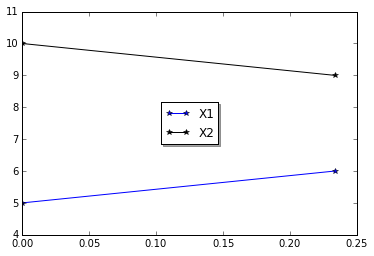

In [14]:
# create arrays containing all data
X1_all = np.array([5, 6]) # initial number and number after one reaction
X2_all = np.array([10, 9]) # initial number and number after one reaction
t_all = np.array([0, t]) # initial time and time of one reaction

# create plot
fig, ax = plt.subplots()
plt.ylim((4,11))
ax.plot(t_all, X1_all, '-*', label='X1')
ax.plot(t_all, X2_all, 'k-*', label='X2')
legend = ax.legend(loc='center', shadow=True)
plt.show()

Return to 1 and repeat.

### Part 3.B. - Automate the process

So now, we need to do the same process many many times, to simulate the system to a maximum time (`tmax`) or maximum number of reactions (`nmax`) of our choice. 

It is not feasible to carry on typing the same commands every time we need to go through the loop until we reach either `tmax` or `nmax` and we need to implement an automated way of **looping** through the algorithm.

So what should we use? You've guessed it - a while loop, because with a while loop we can test whether the `tmax` or `nmax` bounds have been reached and *while* they have not, we go through yet another loop of the algorithm.

Additionally, to be able to visualise the output of every loop, we will also want to provide an automated way of storing the changing values of the reactants, rather than doing it by hand as we did above.

Finally, it is always a good practice to implement a debugging strategy. We recommend defining a *pause* function that will ask the user (of the program) to press the `<ENTER>` key to continue and to print values that will help the user keep track of the algorithm.

To implement these new changes, let's use a new biochemical system, that has more than one reaction. It is important that this system has more than one reaction because if you can write a program general enough to deal with more than one reaction, then there should be no problem with a system with more reactions. Let's use the following system:
```
R1: 2X1 + X2 -> X3
R2: X1 -> 0
```

(**Note on how to represent this system of chemical equations in matrix form:** 
We can write any system on chemical equations in matrix form. First we choose a convention, for example, the rows of the matrix correspond to the reactions and the columns to the reactants. Next, we read off the effect that the reactions have on each of the reactants, for example, R1 consumes 2 (molecules) of X1 and 1 of X2 and produces 1 of X3. Finally, we recod these numbers i correcsponding matrix entries.

For the example above, the array form for the system above would be:

```
    X1 X2 X3
R1  -2 -1  1
R2  -1  0  0
```

You can also choose to write the stoichiometry of the substrates and producs, which which case you only take into account how the substrates/products are affected. So for example, the substrate stoichiometry array of the system above would be:

```
    X1 X2 X3
R1  -2 -1  0
R2  -1  0  0
```

Can yu write the one for the products?)

#### Import required libraries

In [24]:
# import required libraries and modules
import numpy as np
from scipy.special import factorial
import matplotlib.pyplot as plt
%matplotlib inline

#### Define debug function

In [25]:
# define a pause function for debugging
def pause():
    programPause = raw_input("Press the <ENTER> key to continue...")

#### Step 0 of algorithm

In [26]:
# ****************************   
# step 0: input rate values, initial contidions values and initialise time 
# and reactions counter
# ****************************   

# Define the stoichiometry of the system as a numpy array, with the number of reactions in the rows 
# and the number of reactants in the columns. 

    # Define the stochiometry of the substrates and products separatelly; Use the variable names 
    # stoch_subst for the substrates and stoch_prods for the products
    
    # Using these define the stoch variable as the summ of stoch_subst and stoch_prods

    # Keep track of the following:
    # (i ranges 0 -> M-1, where M is the number of reactions, j ranges 0 -> N-1, where N is the 
    # number of species)

    # allocate the number of reactions to variable num_rxn and number of species to varialbe num_spec,
    # use the command shape of numpy and array indexing

stoch_subst = np.array([[-2,-1,0],[-1,0,0]])
stoch_prods = np.array([[0,0,1],[0,0,0]])
stoch = stoch_subst + stoch_prods
s = np.shape(stoch)
num_rxn = s[0]
num_spec = s[1]

# define the ci parameters in an array variable called rates
rates = np.array([0.01,1])

# define the initial conditions of the reactants in an array variable init
init = np.array([90, 3,0])

# specify the maximum time, tmax, and maximum number of reactions, nrmax
tmax = 1
nrmax = 80

# Initialise the current species variable current_species to init.
# Initialise the current time current_t and the time and reaction counters t_count and react_count to 0
current_t = 0
current_species = init
t_count = 0
react_count = 0

# debug: print all the variables to check everything is correct
print "stoch_subst:", '\n',  stoch_subst, '\n', 'stoch_prods:', '\n', stoch_prods, '\n', "stoch:", '\n', stoch, '\n', "s:", '\n', s, '\n', "num_rxn:", '\n', num_rxn, '\n', "num_spec:", '\n', num_spec, '\n', "rates:", '\n', rates, '\n', "init:", '\n', init, '\n', "tmax:", '\n', tmax, '\n', "nrmax:", '\n', nrmax, '\n', "current_t:", '\n', current_t, '\n', "current_species:", '\n', current_species, '\n', "t_count:", '\n', t_count, '\n', "react_count:", '\n', react_count
#pause() 

stoch_subst: 
[[-2 -1  0]
 [-1  0  0]] 
stoch_prods: 
[[0 0 1]
 [0 0 0]] 
stoch: 
[[-2 -1  1]
 [-1  0  0]] 
s: 
(2, 3) 
num_rxn: 
2 
num_spec: 
3 
rates: 
[ 0.01  1.  ] 
init: 
[90  3  0] 
tmax: 
1 
nrmax: 
80 
current_t: 
0 
current_species: 
[90  3  0] 
t_count: 
0 
react_count: 
0


In [27]:
# Initialise variables to store time and molecule numbers
largenum = 2*nrmax
store_t = np.zeros((largenum, 1))
store_mols = np.zeros((largenum, num_spec))
store_r = np.zeros((largenum, 1))

# debug by printing all the variables and check for correct numbers
print "type(store_t):", '\n', type(store_t), '\n', "np.shape(store_t):", '\n', np.shape(store_t), '\n', "type(store_mols):", '\n', type(store_mols), '\n', "np.shape(store_mols)", '\n', np.shape(store_mols)
#pause() 

type(store_t): 
<type 'numpy.ndarray'> 
np.shape(store_t): 
(160, 1) 
type(store_mols): 
<type 'numpy.ndarray'> 
np.shape(store_mols) 
(160, 3)


In [28]:
# store current time and state
store_t[t_count] = current_t
store_mols[t_count,:] = current_species

# debug
print "store_t[0:10]:"
print store_t[0:10]
print 'store_mols[0:10,:]:'
print store_mols[0:10,:]
#pause()

store_t[0:10]:
[[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]]
store_mols[0:10,:]:
[[ 90.   3.   0.]
 [  0.   0.   0.]
 [  0.   0.   0.]
 [  0.   0.   0.]
 [  0.   0.   0.]
 [  0.   0.   0.]
 [  0.   0.   0.]
 [  0.   0.   0.]
 [  0.   0.   0.]
 [  0.   0.   0.]]


#### Define a function to automate the choosing of the next time and reaction and check it works correctly

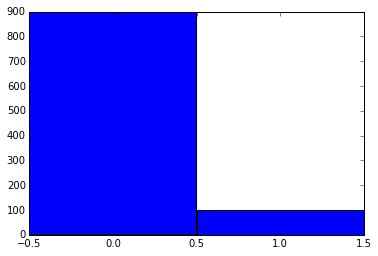

In [29]:
# define a function to choose the next time and reaction
def choose_t_r(a0,a):
    
    # generate random numbers
    r = np.random.random(2)
    r1 = r[0]
    r2 = r[1]
    
    # choose next time increment T
    T = (1/a0)*np.log(1/r1)
    
    # choose next reaction (i ranges 1 -> M, where M is the number of reactions)
    mu = 0
    N = r2*a0 - a[mu]

    while N > 0:
        mu = mu + 1
        N = N - a[mu]

    next_r = mu
    
    return T, next_r 



# To debug choose_t_r write a function that runs choose_t_r 1000 times:

# define function to run choose_t_r
def run_choose_t_r_many_times(a):
    a0 = sum(a)
    
    r = np.zeros((1000,1))

    for i in range(1000):
        #print "simulation: ", i
        res = choose_t_r(a0,a)
        #print "reaction chosen: ", res[1]
        r[i] = res[1]
        #print "r: ", r[:10]
    
    # histogram the reactions chosen
    bins = np.array([-0.5,0.5,1.5])
    plt.hist(r, bins)
    

# Ask youself what you expect the histogram to look like, given the current parameter values:
    # Run function run_choose_t_r_many_times with different values of a:
        # By changing the values of a you can check that different reactions are being chosen 
        # representatively with the system.
        # For example, for a = np.array([9000*0.0001, 10*1]), i.e. the rate for reaction R1 
        # is 0.0001 and for reaction R2 is 1, the proportions of choosing reaction R1 or R2 
        # should be similar, around 1:1, but for a = np.array([9000*0.01, 10*1]) R1 should 
        # be chosen many more times than R2, in fact, on a ratio of around 10:1.

a = np.array([9000*0.01, 10*1])
run_choose_t_r_many_times(a)

#### Automate the calculation of the propensitites of the reactions

Think about how exactly to calculate the algebraic statement that equals `ai = hi*ci`.

It is helpful to write down many examples in order to come up with a formula.

Let's think through this particular example together:

We have the substrate stoichiometry being

```
 -2 -1 0
 -1  0 0
```

suppose we want to work out `hi` for `R1`. Let's start with `X1`. We know that the algebraic expression is `X1(X1-1)`. Notice that this is the same as the binomial coefficient `binom(X1,2)` multiplied by `2!`. (If you don't remember what the binomial coefficient is and how to calculate it, you can refer to the subsection below this explanation.)

Now suppose that the substrate stoichiometry is

```
 -3 -1 0
 -1  0 0
```

to calculate the algebraic expression for `X1`, we know it is `X1*(X1-1)*(X1-2)`, which equals `binom(X1,3)*3!`.

We star to see a pattern here, can you write it down explicitly in Python language? The answer is below, but we encourage you to work it out for yourself. You will need the `binomial` and `factorial` functions. Also, be careful with the signs and remember that you can use the `absolute` function.

.

.

.

.

.

.

.

.

If you did the hand calculations, you saw that to calculate `hi` you need the following formula:

```
hi = hi*binom(current_species[j],np.absolute(stoch_subst[i,j]))*factorial(np.absolute(stoch_subst[i,j]))
```

Unfortunatelly, python does not seem to have a binomial coefficient function, so we define it here (perhaps it is fortunate, it gives us a chance to practice writting a new function! Make sure you understand it). (If you know of an already existing function, let us know!)


(**Side note on the binomial coefficient:** The binomial coefficient, say 4choose2 is the number of ways two objects can be chosen from four objects. For example if I have four letters, A, B, C and D, I can choose:
```
AB
AC
AD
BC
BD
CB
```
and if you stare at this list for a while, you will convince yourself these are all the possible distinct ways of choosing 2 letters out of those 4. So the binomial coefficient 4choose2 = 6.

In general, you do not write all the possibilities down. You use a formula: NchooseK = N!/K!(N-K)! where the factorial, say 5! means that you multiply all the integers from 5 down to 1 together, to get `5*4*3*2*1 = 120`.

If you want to check various binomial coefficients, you can go to [WolframAlpha](http://www.wolframalpha.com/) and use binom[n,m] to make the calculations.)

In [30]:
# define a function to calculate the binomial coefficient
def binom(n,m):
    b=[0]*(n+1)
    b[0]=1
    for i in xrange(1,n+1):
        b[i]=1
        j=i-1
        while j>0:
            b[j]+=b[j-1]
            j-=1
    return b[m]

# debug - test binom
print binom(5,0), binom(5,1), binom(5,2), binom(5,3), binom(5,4), binom(5,5)
#pause()

1 5 10 10 5 1


#### Write the main loop of the algorithm - Steps 1, 2 and 3

In [31]:
# Now we write the main loop. Remember it is important to print values and using 
# the pause function to help yourself to debug the program.

# debug
print "current_species: ", current_species
print "rates: ", rates

# while main loop
#while react_count < nrmax:
while current_t < tmax:
    
    # ****************************   
    # step 1: calculate ai and a0
    # ****************************   
    
    # debug
    print "step 1: calculate ai and a0"
    
    a = np.ones((num_rxn,1))
    
    # (recall i ranges 1 -> M, where M is the number of reactions, j ranges 1 -> N, where N is the number of species)
    for i in range(num_rxn):
        hi = 1
        for j in range(len(init)):
            
            # check the reactant is involved in this reaction
            if stoch_subst[i,j] == 0:
                continue
            else:
                    
                # check the reactant has molecules available
                
                    # if it does not, go to the next reactant
                if current_species[j] <= 0:
                    to_print = "Reactant X{} has {} molecules".format(j,0)
                    print to_print
                    hi = 0
                    continue
                
                    # if it does, calculate hi
                else:
            
                    # debug
                    print "reaction (i):", i
                    print "reactant (j):", j
                    print "current_species[j]:", current_species[j]
                    print "stoch_subst[i,j]:", stoch_subst[i,j]
                    print "np.absolute(stoch_subst[i,j]):", np.absolute(stoch_subst[i,j])
                    print "binom(current_species[j],np.absolute(stoch_subst[i,j]):", binom(current_species[j],np.absolute(stoch_subst[i,j]))            
                    print "factorial(np.absolute(stoch_subst[i,j])):", factorial(np.absolute(stoch_subst[i,j]))
                    print "int(factorial(np.absolute(stoch_subst[i,j]))):", int(factorial(np.absolute(stoch_subst[i,j])))
                    print "binom(current_species[j],np.absolute(stoch_subst[i,j]))*factorial(np.absolute(stoch_subst[i,j])):", binom(current_species[j],np.absolute(stoch_subst[i,j]))*factorial(np.absolute(stoch_subst[i,j]))            
                    #pause()

                    hi = hi*binom(current_species[j],np.absolute(stoch_subst[i,j]))*factorial(np.absolute(stoch_subst[i,j]))

                    # debug
                    print "hi: ", hi
        
        # debug
        print "hi: ", hi
        
        a[i] = hi*rates[i]

        # debug
        print "a[i]: ", a[i]
        #pause()
        
    a0 = sum(a)
    print a0
    
    # ****************************   
    # step 2: choose next t and r
    # ****************************   

    # debug
    print "step 2: choose next t and r"

    tr = choose_t_r(a0,a)
    dt = tr[0]
    next_r = tr[1]
    
    # debug
    print dt, next_r
    print "next_r should be an integer"
    #pause()
    
    # ****************************   
    # step 3: update and store system
    # ****************************   
    
    # debug
    print "step 3: update and store system"
                          
    # debug
    print current_t, current_species
    #pause()

    # update system
    current_t = current_t + dt
    current_species = current_species + np.transpose(stoch[next_r,:])
    
    # debug
    print current_t, current_species
    #pause()
    
    # debug
    print "t_count:", t_count
    print "react_count:", react_count
    #pause()
    
    # update time counter and reaction counter
    t_count = t_count + 1
    react_count = react_count + 1
    
    # debug
    print "t_count:", t_count
    print "react_count:", react_count
    #pause()
    
    # store current system
    store_t[t_count] = current_t
    store_mols[t_count,:] = current_species 
    store_r[t_count] = next_r

    # debug
    print store_t[0:10], store_mols[0:10,:]
    #pause()

current_species:  [90  3  0]
rates:  [ 0.01  1.  ]
step 1: calculate ai and a0
reaction (i): 0
reactant (j): 0
current_species[j]: 90
stoch_subst[i,j]: -2
np.absolute(stoch_subst[i,j]): 2
binom(current_species[j],np.absolute(stoch_subst[i,j]): 4005
factorial(np.absolute(stoch_subst[i,j])): 2.0
int(factorial(np.absolute(stoch_subst[i,j]))): 2
binom(current_species[j],np.absolute(stoch_subst[i,j]))*factorial(np.absolute(stoch_subst[i,j])): 8010.0
hi:  8010.0
reaction (i): 0
reactant (j): 1
current_species[j]: 3
stoch_subst[i,j]: -1
np.absolute(stoch_subst[i,j]): 1
binom(current_species[j],np.absolute(stoch_subst[i,j]): 3
factorial(np.absolute(stoch_subst[i,j])): 1.0
int(factorial(np.absolute(stoch_subst[i,j]))): 1
binom(current_species[j],np.absolute(stoch_subst[i,j]))*factorial(np.absolute(stoch_subst[i,j])): 3.0
hi:  24030.0
hi:  24030.0
a[i]:  [ 240.3]
reaction (i): 1
reactant (j): 0
current_species[j]: 90
stoch_subst[i,j]: -1
np.absolute(stoch_subst[i,j]): 1
binom(current_species[j],

#### Collect and plot results of simulations

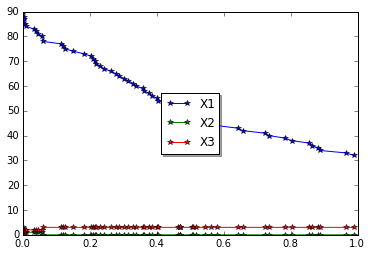

(array([  4.,  52.]), array([-0.5,  0.5,  1.5]), <a list of 2 Patch objects>)

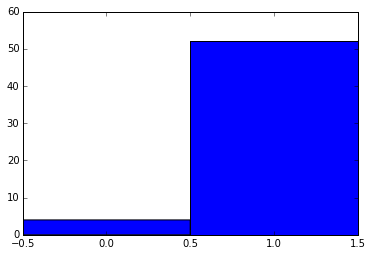

In [32]:
# store final output
store_t = store_t[:t_count]
store_mols = store_mols[:t_count,:]
store_r = store_r[:t_count]
                          
# plot of simulation
fig, ax = plt.subplots()
ax.plot(store_t, store_mols[:,0], '-*', label='X1')
ax.plot(store_t, store_mols[:,1], '-*', label='X2')
ax.plot(store_t, store_mols[:,2], '-*', label='X3')
legend = ax.legend(loc='center', shadow=True)
plt.show()

# histogram of reactions chosen by algorithm
bins = np.array([-0.5,0.5,1.5])
plt.hist(store_r, bins)

### Part 3.C. Make the algorithm into a function so that you can run it with *any* biochemical system

Now, it would be great if we could just call a function that would work for any set of reactions and that we can just run one line of code rather than the whole set up and while loop over and over. We do this below. (Note that you can now get rid of the debugging commands as we have tested every bit and it is all working and we want the program to run smoothly without user input.)

#### Program the algorithm as a function

In [41]:
# ----------------------------
# ----------------------------
# IMPORT ALL NECESSARY LIBRARIES AND MODULES
# ----------------------------
# ----------------------------

# import required libraries and modules
import numpy as np
from scipy.special import factorial
import matplotlib.pyplot as plt
%matplotlib inline

# ----------------------------
# ----------------------------
# DEFINE OTHER FUNCTIONS NECESSARY
# ----------------------------
# ----------------------------

# define a function to choose the next time and reaction
def choose_t_r(a0,a):
    
    # generate random numbers
    r = np.random.random(2)
    r1 = r[0]
    r2 = r[1]
    
    # choose next time
    T = (1/a0)*np.log(1/r1)
    
    # choose next reaction (i ranges 1 -> M, where M is the number of reactions)
    i = 0
    N = r2*a0 - a[i]

    while N > 0:
        i = i + 1
        N = N - a[i]

    next_r = i
    
    return T, next_r 


# define a function to calculate the binomial coefficient
def binom(n,m):
    b=[0]*(n+1)
    b[0]=1
    for i in xrange(1,n+1):
        b[i]=1
        j=i-1
        while j>0:
            b[j]+=b[j-1]
            j-=1
    return b[m]


# ----------------------------
# ----------------------------
# DEFINE SIMULATION FUNCTION
# ----------------------------
# ----------------------------

def my_gillespie(init, rates, stoch_subst, stoch_prods, tmax, nrmax):
    
    # ****************************   
    # step 0: input rate values, initial contidions values and initialise time and reactions counter
    # ****************************   

    # define the stoichiometry of the system as a numpy array
    stoch = stoch_subst + stoch_prods
    s = np.shape(stoch)
    num_rxn = s[0]
    num_spec = s[1]

    # initialise current time and current species variables and the time and reaction counters
    current_t = 0
    current_species = init
    t_count = 0
    react_count = 0

    # initialise variables to store time and molecule numbers
    largenum = 2*nrmax
    store_t = np.zeros((largenum, 1))
    store_mols = np.zeros((largenum, num_spec))
    store_r = np.zeros((largenum, 1))

    # store current time and state of system
    store_t[t_count] = current_t
    store_mols[t_count,:] = current_species

    # while main loop
    #while react_count < nrmax:
    while current_t < tmax:
        
        # ****************************   
        # step 1: calculate ai and a0
        # ****************************   

        a = np.ones((num_rxn,1))

        # (i ranges 1 -> M, where M is the number of reactions, j ranges 1 -> N, where N is the number of species)
        for i in range(num_rxn):
            hi = 1
            for j in range(len(init)):

                # check the reactant is involved in this reaction
                if stoch_subst[i,j] == 0:
                    continue
                else:

                    # check the reactant has molecules available
                    if current_species[j] <= 0:
                        to_print0 = "Loop {}".format(t_count)
                        to_print = "Reactant X{} has {} molecules".format(j,0)
                        print to_print0
                        print to_print
                        hi = 0
                        continue
                    else:
                        hi = hi*binom(current_species[j],np.absolute(stoch_subst[i,j]))*factorial(np.absolute(stoch_subst[i,j]))

            a[i] = hi*rates[i]

        a0 = sum(a)

        # ****************************   
        # step 2: choose next t and r
        # ****************************   

        tr = choose_t_r(a0,a)
        dt = tr[0]
        next_r = tr[1]


        # ****************************   
        # step 3: update and store system
        # ****************************   

        # update system
        current_t = current_t + dt
        current_species = current_species + np.transpose(stoch[next_r,:])

        # update time counter and reaction counter
        t_count = t_count + 1
        react_count = react_count + 1

        # store current system
        store_t[t_count] = current_t
        store_mols[t_count,:] = current_species 
        store_r[t_count] = next_r

    # store final output
    store_t = store_t[:t_count]
    store_mols = store_mols[:t_count,:]
    store_r = store_r[:t_count]
    
    return store_t, store_mols, store_r


#### Run a few simulations with different scenarios

Loop 8
Reactant X1 has 0 molecules
Loop 9
Reactant X1 has 0 molecules
Loop 10
Reactant X1 has 0 molecules
Loop 11
Reactant X1 has 0 molecules
Loop 12
Reactant X1 has 0 molecules
Loop 13
Reactant X1 has 0 molecules
Loop 14
Reactant X1 has 0 molecules
Loop 15
Reactant X1 has 0 molecules
Loop 16
Reactant X1 has 0 molecules
Loop 17
Reactant X1 has 0 molecules
Loop 18
Reactant X1 has 0 molecules
Loop 19
Reactant X1 has 0 molecules
Loop 20
Reactant X1 has 0 molecules
Loop 21
Reactant X1 has 0 molecules
Loop 22
Reactant X1 has 0 molecules
Loop 23
Reactant X1 has 0 molecules
Loop 24
Reactant X1 has 0 molecules
Loop 25
Reactant X1 has 0 molecules
Loop 26
Reactant X1 has 0 molecules
Loop 27
Reactant X1 has 0 molecules
Loop 28
Reactant X1 has 0 molecules
Loop 29
Reactant X1 has 0 molecules
Loop 30
Reactant X1 has 0 molecules
Loop 31
Reactant X1 has 0 molecules
Loop 32
Reactant X1 has 0 molecules
Loop 33
Reactant X1 has 0 molecules
Loop 34
Reactant X1 has 0 molecules
Loop 35
Reactant X1 has 0 mole

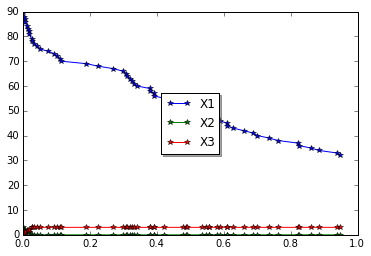

(array([  4.,  52.]), array([-0.5,  0.5,  1.5]), <a list of 2 Patch objects>)

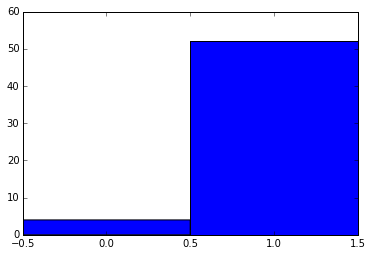

In [42]:

# ----------------------------
# ----------------------------
# RUN SIMULATION
# R1: X1 + X2 -> 2X1
# R2: X1 -> 0
# ----------------------------
# ----------------------------

# ****************************
# step A: define rate values, initial contidions values, tmax and nrmax
# ****************************

# define the stochiometry of the substrates and products separatelly
stoch_subst = np.array([[-2,-1,0],[-1,0,0]])
stoch_prods = np.array([[0,0,1],[0,0,0]])

# define the ci parameters (rates)
rates = np.array([0.01,1])

# define the initial conditions of the reactants
init = np.array([90, 3,0])

# define the maximum time, tmax, and and maximum number of reactions, nrmax
tmax = 1
nrmax = 80

# ****************************
# step B: run simulation
# ****************************
results = my_gillespie(init, rates, stoch_subst, stoch_prods, tmax, nrmax)

# ****************************
# step C: plot results
# ****************************

# plot of simulation

# define vars
store_t = results[0]
store_mols = results[1]
store_r = results[2]

# plot results
fig, ax = plt.subplots()
ax.plot(store_t, store_mols[:,0], '-*', label='X1')
ax.plot(store_t, store_mols[:,1], '-*', label='X2')
ax.plot(store_t, store_mols[:,2], '-*', label='X3')
legend = ax.legend(loc='center', shadow=True)
plt.show()

# histogram of reactions chosen by algorithm
bins = np.array([-0.5,0.5,1.5])
plt.hist(store_r, bins)



Loop 0
Reactant X1 has 0 molecules
Loop 0
Reactant X1 has 0 molecules
Loop 0
Reactant X2 has 0 molecules
Loop 1
Reactant X2 has 0 molecules


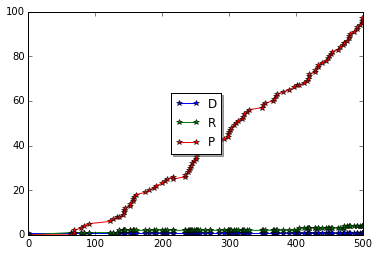

(array([  5.,  98.]), array([-0.5,  0.5,  1.5]), <a list of 2 Patch objects>)

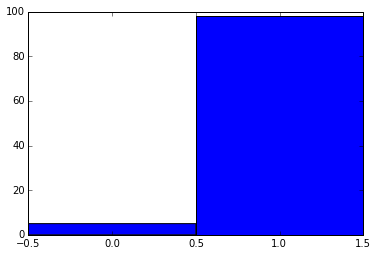

In [63]:
# ----------------------------
# ----------------------------
# RUN SIMULATION
# R1: D -> D + R
# R2: R -> R + P
# R3: R -> 0
# R4: P -> 0
# ----------------------------
# ----------------------------

# ****************************
# step A: define rate values, initial contidions values, tmax and nrmax
# ****************************

# define the stochiometry of the substrates and products separatelly
stoch_subst = np.array([[-1, 0, 0],[0, -1, 0], [0, -1, 0], [0, 0, -1]])
stoch_prods = np.array([[1,1,0],[0,1,1],[0,0,0],[0,0,0]])

# define the ci parameters (rates)
rates = np.array([0.01,0.1,0.0001,0.0001])

# define the initial conditions of the reactants
init = np.array([1,0,0])

# define the maximum time, tmax, and and maximum number of reactions, nrmax
tmax = 500
nrmax = 80

# ****************************
# step B: run simulation
# ****************************
results = my_gillespie(init, rates, stoch_subst, stoch_prods, tmax, nrmax)

# ****************************
# step C: plot results
# ****************************

# plot of simulation

# define vars
store_t = results[0]
store_mols = results[1]
store_r = results[2]

# plot results
fig, ax = plt.subplots()
ax.plot(store_t, store_mols[:,0], '-*', label='D')
ax.plot(store_t, store_mols[:,1], '-*', label='R')
ax.plot(store_t, store_mols[:,2], '-*', label='P')
legend = ax.legend(loc='center', shadow=True)
plt.show()

# histogram of reactions chosen by algorithm
bins = np.array([-0.5,0.5,1.5])
plt.hist(store_r, bins)



## Part 4. Next steps

### Stochastic vs deterministic

Probably the bext thing you can try to do it to compare the results of these stochastic simulations with results you would get when you model the same systems deterministically, with a system of Ordinary Differential Equations (ODEs). This will actually validate our stochastic simulation algorithm.

Note that ODE modelling is performed in terms of concentrations and deterministic rate constants; and stochastic calculations are in stochastic constants and molecule numbers. So for the results to be comparable, we need to make conversions properly. Luckily, Gillespie spells this out for us in his paper and if you are interested, you can have a look at page 2343, section IIC. Connection with the Deterministic Reaction-Rate Constant. 

Recall the stochastic reaction rate constant is `c_i`, which we introduced in Part 2.

Let's denote the deterministic rate constant for reaction `R_i` with `k_i`.

The conclusion of Gillespie's analysis is that 

```
k_i = (V^(m-1))*c_i
```

The presence of the factor `V^(m-1)`, where `m` is the number of reactant molecules in reaction `R_i`, is merely a consequence of the fact that the reaction-rate constant is normally used in differential equations that contain molecular concentrations (numbers of molecules per unit volume) rather than total numbers of molecules. For example, if reaction `R_i` had three reactant molecules, we would have `V^2` instead of `V`;if `R_i`had only one reactant molecule (a simple isomerization), the factor `V` would be absent.

Furthermore, in general, if `R`, has `n` identical reactant molecules, then `c` will be larger than `k` by a factor of `n!`. So, for example, if we have `R: 2X1 -> X2` then `k=V*c/2`.

So let's translate the following system and simulate it deterministically (if you need to learn this topic or prefresh your memory, we refer you to [this](https://github.com/karinsasaki/biomath-modelling-with-python) tutorial):
```
R1: D -> D + R
R2: R -> R + P
R3: R -> 0
R4: P -> 0
```

We had defined the stochastic rate constants as follows:

```
c1 = 0.01
c2 = 0.1
c3 = 0.0001
c4 = 0.0001
```

Let's assume the volume of the system is 1, then the deterministic rate constants are:

```
k1 = 0.01
k2 = 0.1
k2 = 0.0001
k2 = 0.0001
```

The same! Why? because there is only one reactant molecule in each reaction.

Now we show how to simulate the system deterministically:

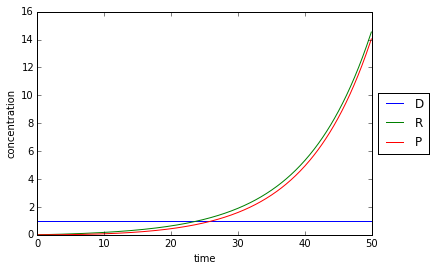

In [54]:
# import modules and libraries
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
%matplotlib inline

# Parameters
k1 = 0.01
k2 = 0.1
k3 = 0.0001
k4 = 0.0001
params = (k1, k2, k3, k4)

# Initial conditions
D_0 = 1
R_0 = 0
P_0 = 0
ini = (D_0, R_0, P_0)

# Time
dt = 0.1
t = np.arange(0,50,dt)

# ODE system (in format used for odeint)
def myODE(init,t,params):
    
    k1, k2, k3, k4 = params
    
    D, R, P = init

    # rates
    v1 = k1*D
    v2 = k2*R
    v3 = k3*R
    v4 = k4*P
    
    # equations
    dD = 0
    dR = v1 + v2 - v3
    dP = v2 - v4
        
    return (dD, dR, dP)

# Solve using odeint from scipy.integrate
solution = odeint(myODE,ini,t,args=(params,)) 
tD = solution[:,0]
tR = solution[:,1]
tP = solution[:,2]

# Show over time
fig, ax = plt.subplots()
ax.plot(t, tD, label='D')
ax.plot(t, tR, label='R')
ax.plot(t, tP, label='P')
plt.xlabel('time')
plt.ylabel('concentration')
legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### Exercise

Demonstrate the effect of sample volume on the simulation results. Keep concentration the same and run simulations for different volumes (each time converting concentrations to molecule numbers). Show that for small volumes stoshastic curves are not completely reproducible and deviate from deterministic solution. For large volumes stochastic and deterministic solutions should be very close.


## Part 5. The end

Next, as we have metioned before, the algorithm that we have written here is not the most computationally speedy and there are modifications of the Gillespie algorithm that are much more efficient. You could have a look at the difference in efficiency with the reaction method (Gibson & Bruck) and the tau-leaping method.


This is the end of the tutorial. Good job on finishing it! 